# Project Name: Lyric Generator
Description:
Implementing a Deep Neural network using LSTMs to create a character based lyric generator

Details:
1. step size: 40
2. batch size: 128
3. Epochs: 100
4. Songs: 1000

### Importing Libraries

In [160]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation,LSTM,Dense,CuDNNLSTM, Flatten, Bidirectional, Dropout
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
np.random.seed(10)

### Design Parameters

In [124]:
BATCH_SIZE = 32
maxlen = 10 ##timesteps
epochs = 30
MIN_WORD_FREQUENCY = 10
song_count = 1000

In [125]:
def load_lyrics(path):
    '''
    Function to load lyrics of all the artists in the input path
    '''
    lyrics = ""
    for fn in os.listdir(path):
        with open(os.path.join(path, fn), 'r') as song:
            song_lyrics = clean_string(song.read())
            lyrics += song_lyrics
    return lyrics

def clean_string(string):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    string = string.lower()  # lowercase

    clean_words = []
    for word in string.split():
        # clean words with quotation marks on only one side
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)

### Reading Input
Parameters: 10 songs

In [126]:
## Reading the scraped Rap songs
text = load_lyrics("./RapLyrics-Scraper/my_lyrics_folder/")

In [127]:
## Reading the kaggle input ~55k songs
df=pd.read_csv('./songdata.csv')['text'][:song_count]
data=np.array(df)

In [77]:
## Reading the scraped pink floyed songs
df=pd.read_csv('./pink_floyd_lyrics.csv',header=0, error_bad_lines=False, delimiter='\t')['text']
df = df.fillna('')
data=np.array(df)

In [78]:
data[1]

"I took my troubles down to Madame Rue.\nYou know that gypsy with the gold capped tooth\nShe's got a pad down on 34th and Vine,\nSelling little bottles of Love Potion #9.\nI told her that I was a flop with chicks.\nI've been disgraced since 1956.\nShe looked at my palm and she made a magic sign.\nShe said what you need is Love Potion #9.\nShe bent down and turned around and gave me a wink.\nShe said I'm gonna make it up right here in the sink.\nIt smelled like turpentine, and looked like Indian ink.\nI held my nose, I closed my eyes, I took a drink!\nI didn't know if it was day or night.\nI started kissing everything in sight.\nBut when I kissed a cop down on 34th and Vine.\nHe broke my little bottle of Love Potion #9.\n(instrumental)\nI held my nose, I closed my eyes, I took a drink!\nI didn't know if it was day or night.\nI started kissing everything in sight.\nBut when I kissed a cop down on 34th and Vine.\nHe broke my little bottle of Love Potion #9.\nLove Potion #9...\nLove Potion

### Creating corpus(all the characters in all the songs concatenated)
1. Converting all the characters to lower

In [128]:
# text=''
# for ix in range(len(data)):
#     text+=data[ix]
text = text.lower()
corpus = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
print('Corpus length in words:', len(corpus))

Corpus length in words: 449300


### Filtering vocabulary based on word frequency

In [129]:
word_freq = {}
for word in corpus:
    word_freq[word] = word_freq.get(word, 0) + 1

ignored_words = set()
for k, v in word_freq.items():
    if word_freq[k] < MIN_WORD_FREQUENCY:
        ignored_words.add(k)

In [130]:
vocab = set(corpus)
print('Unique words before ignoring:', len(vocab))
print('Ignoring words with frequency <', MIN_WORD_FREQUENCY)
vocab = sorted(set(vocab) - ignored_words)
print('Unique words after ignoring:', len(vocab))
# print_vocabulary(vocabulary, words)

Unique words before ignoring: 29207
Ignoring words with frequency < 10
Unique words after ignoring: 3357


### Creating Vocabulary and char, index mappings

In [131]:
word_ix={c:i for i,c in enumerate(vocab)}
ix_word={i:c for i,c in enumerate(vocab)}

### Filtering corpus based on new vocabulary

In [132]:
sentences = []
next_words = []
ignored = 0
for i in range(0, len(corpus) - maxlen):
    # Only add the sequences where no word is in ignored_words
    if len(set(corpus[i: i+maxlen+1]).intersection(ignored_words)) == 0:
        sentences.append(corpus[i: i + maxlen])
        next_words.append(corpus[i + maxlen])
    else:
        ignored = ignored + 1
print('Ignored sequences:', ignored)
print('Remaining sequences:', len(sentences))

Ignored sequences: 295526
Remaining sequences: 153764


### Creating the train and test datasets

In [133]:
split_count = int(0.8 * len(sentences))
sentences_test = sentences[split_count:]
next_words_test = next_words[split_count:]
sentences = sentences[:split_count]
next_words = next_words[:split_count]

### Check vocab size and corpus size

In [134]:
vocab_size=len(vocab) ##Dimentions of each char
print(vocab_size)

3357


In [135]:
len(corpus)

449300

In [136]:
def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, word_ix[w]] = 1
            y[i, word_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [163]:
def create_model(timesteps, vocab_size, no_layers=2,dropout=0.2):
    '''
    Creating the model
    '''
    model=Sequential()
#     for i in range(no_layers):
#         model.add(CuDNNLSTM(128,input_shape=(timesteps,vocab_size), return_sequences=True))
#     model.add(Flatten())
    model.add(Bidirectional(CuDNNLSTM(128), input_shape=(timesteps,vocab_size)))
    model.add(Dropout(dropout))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')
    return model

In [164]:
model = create_model(maxlen, vocab_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 256)               3570688   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3357)              862749    
_________________________________________________________________
activation_8 (Activation)    (None, 3357)              0         
Total params: 4,433,437
Trainable params: 4,433,437
Non-trainable params: 0
_________________________________________________________________


In [165]:
def sample(preds, temperature=1.0):
    '''
    helper function to sample an index from a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]
#     print(seed)

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, maxlen, vocab_size))
#             print("sentence len: {0}".format(len(sentence)))
            for t, word in enumerate(sentence):
#                 print(word)
                x_pred[0, t,word_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_word_pred = ix_word[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence.append(next_word_pred)

            examples_file.write(" "+next_word_pred)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
#     examples_file.flush()

### Opening the output file

In [166]:
examples_file = open("output_data_word.txt", "w")

### Training the model

In [167]:
file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % (
    len(vocab),
    maxlen,
    10
)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)

checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callbacks_list = [print_callback, cp_callback]
history = model.fit_generator(generator(sentences, next_words, BATCH_SIZE),
    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
    epochs=epochs,
    validation_data=generator(sentences_test, next_words_test, BATCH_SIZE)
                    ,validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
                   callbacks = callbacks_list)

Epoch 1/30
3845/3845 [==============================] - 129s 33ms/step - loss: 5.5402 - val_loss: 5.8227

Epoch 00001: saving model to cp.ckpt
Epoch 2/30
3845/3845 [==============================] - 127s 33ms/step - loss: 4.4583 - val_loss: 5.9419

Epoch 00002: saving model to cp.ckpt
Epoch 3/30
3845/3845 [==============================] - 129s 33ms/step - loss: 3.5856 - val_loss: 6.2098

Epoch 00003: saving model to cp.ckpt
Epoch 4/30
3845/3845 [==============================] - 129s 33ms/step - loss: 2.9226 - val_loss: 6.6544

Epoch 00004: saving model to cp.ckpt
Epoch 5/30
3687/3845 [===========================>..] - ETA: 4s - loss: 2.4672

KeyboardInterrupt: 

### Closing the output file

In [93]:
examples_file.close()

### Plotting Train Loss curve

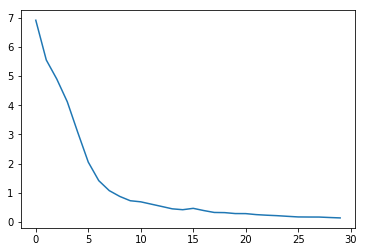

In [94]:
plt.plot(history.history['loss'])

### Plotting Validation Loss curve

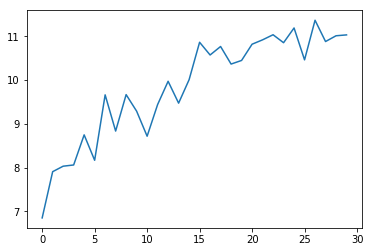

In [95]:
plt.plot(history.history['val_loss'])

### Saving the model to disk

In [96]:
model.save('keras_model_word.hdf5')
# loaded_model = keras.models.load_model('keras_model_word.hdf5')

### Loading the model

In [97]:
#loaded_model = keras.models.load_model('keras_model.hdf5')

### Testing the model

In [101]:
def predict_n(model, input_seq, len_out=10):
    generated = []
    actual = []
    # sent=txt[start_index:start_index+maxlen]
    sent = input_seq
    generated += sent
    gen = generated
    for i in range(len_out):
        x_sample=generated[i:i+maxlen]
        x = np.zeros((1,maxlen,vocab_size))
        for j in range(maxlen):
            x[0,j,word_ix[x_sample[j]]] = 1
        probs = model.predict(x)
        probs = np.reshape(probs,probs.shape[1])
        ix = np.argmax(probs)
    #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
        generated.append(ix_word[ix])
    return " ".join(generated)

In [106]:
inp = "Is there anybody in there?\nJust nod if you can hear me\nIs there anyone at home?"
inp_seq = inp.lower().split(" ")[:10]

In [107]:
predict_n(model, inp_seq, 10)

KeyError: 'anybody'

In [100]:
# txt = corpus
# start_index = 230
for j in range(min(50, len(sentences_test))):
    generated = []
    actual = []
    # sent=txt[start_index:start_index+maxlen]
    sent = sentences_test[j]
    generated += sent
    actual += sent
    print("Input - ",generated)
    gen = generated
    for i in range(min(100,len(generated))):
        x_sample=generated[i:i+maxlen]
        x = np.zeros((1,maxlen,vocab_size))
        for j in range(maxlen):
            x[0,j,word_ix[x_sample[j]]] = 1
        probs = model.predict(x)
        probs = np.reshape(probs,probs.shape[1])
        ix = np.argmax(probs)
    #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
        generated.append(ix_word[ix])
        actual.append(next_words_test[i])
    # for i in range(100):
    #     x_sample=gen[i:i+maxlen]
    #     x=np.zeros((1,maxlen,vocab_size))
    #     for j in range(maxlen):
    #         x[0,j,char_ix[x_sample[j]]]=1
    #     probs=loaded_model.predict(x)[0]
    #     ix = np.argmax(probs)
    # #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
    #     gen+=ix_char[ix]
    # # print("--------------")
    print("Generated ############### ")
    print(" ".join(generated))
    print()
    print("Actual ###############")
    print(" ".join(actual))

Input -  ['take', 'you', 'down,', "'cause", "i'm", 'going', 'to', 'strawberry', 'fields.\nnothing', 'is']
Generated ############### 
take you down, 'cause i'm going to strawberry fields.
nothing is real and nothing to get hung about
strawberry fields forever
strawberry fields

Actual ###############
take you down, 'cause i'm going to strawberry fields.
nothing is real and nothing to get hung about.
strawberry fields when it's
Input -  ['you', 'down,', "'cause", "i'm", 'going', 'to', 'strawberry', 'fields.\nnothing', 'is', 'real']
Generated ############### 
you down, 'cause i'm going to strawberry fields.
nothing is real and nothing to get hung about
strawberry fields forever
strawberry fields forever
strawberry

Actual ###############
you down, 'cause i'm going to strawberry fields.
nothing is real real and nothing to get hung about.
strawberry fields when it's
Input -  ['down,', "'cause", "i'm", 'going', 'to', 'strawberry', 'fields.\nnothing', 'is', 'real', 'and']
Generated ##########

Generated ############### 
rocking in boston
philadelphia, pa
deep in the heart of texas
on down (i'm really down)
how can you laugh when you know you

Actual ###############
rocking in boston
philadelphia, pa
deep in the heart of texas
on down real and nothing to get hung about.
strawberry fields when it's
Input -  ['in', 'boston\nphiladelphia,', 'pa\ndeep', 'in', 'the', 'heart', 'of', 'texas\non', 'down', 'in']
Generated ############### 
in boston
philadelphia, pa
deep in the heart of texas
on down in the movies
then i know that you will plainly see
the biggest

Actual ###############
in boston
philadelphia, pa
deep in the heart of texas
on down in real and nothing to get hung about.
strawberry fields when it's
Input -  ['boston\nphiladelphia,', 'pa\ndeep', 'in', 'the', 'heart', 'of', 'texas\non', 'down', 'in', 'frisco']
Generated ############### 
boston
philadelphia, pa
deep in the heart of texas
on down in frisco pans
i said get out of that kitchen
and shake those pots

Actual ####

Generated ############### 
boston
philadelphia, pa
deep in the heart of texas
on down in frisco pans
i said get out of that kitchen
and shake those pots

Actual ###############
boston
philadelphia, pa
deep in the heart of texas
on down in frisco real and nothing to get hung about.
strawberry fields when it's
Input -  ['pa\ndeep', 'in', 'the', 'heart', 'of', 'texas\non', 'down', 'in', 'frisco', 'bay\nall']
Generated ############### 
pa
deep in the heart of texas
on down in frisco bay
all the loving, baby
please please pleasethough i keep trying hard
to make

Actual ###############
pa
deep in the heart of texas
on down in frisco bay
all real and nothing to get hung about.
strawberry fields when it's
Input -  ['in', 'the', 'heart', 'of', 'texas\non', 'down', 'in', 'frisco', 'bay\nall', 'over']
Generated ############### 
in the heart of texas
on down in frisco bay
all over once, move over twice
come on baby don't be cold as

Actual ###############
in the heart of texas
on down in frisco ba

In [99]:
print("Generated ############### ")
print(" ".join(generated))
print()
print("Actual ###############")
print(" ".join(actual))

Generated ############### 
take you down, 'cause i'm going to strawberry fields.
nothing is real and nothing to get hung about
strawberry fields forever
strawberry fields

Actual ###############
take you down, 'cause i'm going to strawberry fields.
nothing is real and nothing to get hung about.
strawberry fields when it's


### Credits

In [ ]:
1. https://github.com/fpaupier/RapLyrics-Scraper/blob/master/lyrics_scraper.py
2. https://towardsdatascience.com/ai-generates-taylor-swifts-song-lyrics-6fd92a03ef7e
3. 